# Classification

## MNIST

### Load dataset

In [22]:
from sklearn.datasets import fetch_openml

X_mnist, y_mnist = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

print(f"features size: {X_mnist.shape}\nlabels size:{y_mnist.shape}")

features size: (70000, 784)
labels size:(70000,)


### Visualize data

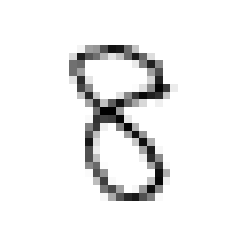

In [23]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

X, y = X_mnist, y_mnist

some_digit = X[3600]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary,
           interpolation='nearest')
plt.axis('off')
plt.show()

In [24]:
print(f"This is number: {y[3600]}")

This is number: 8


### Split data into train and test set

In [25]:
from sklearn.model_selection import train_test_split
from sklearn import random

random.seed(2910)

X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=True,train_size=0.9 ,random_state=2910)


print(f"Train size: {X_train.shape}, {y_train.shape}")
print(f"Test size: {X_test.shape}, {y_test.shape}")


Train size: (63000, 784), (63000,)
Test size: (7000, 784), (7000,)


## Training a Binary Classifier

Đưa bài toán trở về đơn giản với binary classifier, xác định đâu là số 8.

In [26]:
y_train_8 = (y_train == '8')
y_test_8= (y_test == '8')


In [27]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=2910)
sgd_clf.fit(X_train, y_train_8)


SGDClassifier(random_state=2910)

### Make prediction with image show above

In [28]:
sgd_clf.predict([some_digit])

array([ True])

## Performance Measures

### Measuring accuracy using cross-validation

Sử dụng `StratifiedKfold`

In [29]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=2910, shuffle=True)

for train_idx, test_idx in skfolds.split(X_train, y_train_8):
    clone_clf = clone(sgd_clf)
    
    X_train_folds = X_train[train_idx]
    y_train_folds = y_train_8[train_idx]
    
    X_test_folds = X_train[test_idx]
    y_test_folds = y_train_8[test_idx]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    
    print(n_correct / len(y_pred))
    

0.9330952380952381
0.9221428571428572
0.9268095238095239


Sử dụng `cross_val_score`

In [30]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_8, cv=3, scoring='accuracy')

array([0.93833333, 0.92771429, 0.92390476])

Có một vấn đề là độ chính xác (accuracy) không phải là một cách đánh giá performance nên được dùng của một classifier. Lấy ví dụ ta sẽ sử dụng một classifier luôn luôn cho ra dự đoán là dữ liệu này chính là số 8.

Cùng xem qua tập dữ liệu:

In [31]:
print(f"Number of 8 class: {sum(y_train_8)}")
print(f"Number of not 8 class: {len(y_train_8) - sum(y_train_8)}")

print(f"Ratio of num_8/total = {1- sum(y_train_8)/len(y_train_8)}")

Number of 8 class: 6152
Number of not 8 class: 56848
Ratio of num_8/total = 0.9023492063492063


Như vậy ta có tỷ lệ các số không phải là 8 tầm 90%

Bây giờ ta sẽ viết classifier luôn luôn cho ra dự đoán dữ liệu chính là số 8

In [32]:
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_score
import numpy as np


class NeverEightClf(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
    
    
never_8_clf = NeverEightClf()

cross_val_score(never_8_clf, X_train, y_train_8, cv=3, scoring='accuracy')

array([0.90119048, 0.899     , 0.90685714])

Accuracy thu được là 90%, điều này là hiển nhiên vì như ta đã thấy từ đầu là có 90% data không phải 8 và 10% là số 8. Như vậy model luôn dự đoán data không phải là 8 thì đương nhiên sẽ có ít nhất là 90% accuracy

### Confusion Matrix

Một cách tốt hơn để có thể đánh giá hiệu năng của `classifier` là nhìn vào `confusion matrix`. Ý tưởng là đếm số lần mà class A bị classified nhầm thành class B. Ví dụ, để biết số lần bị phần biệt nhầm của 5s thành 3s thì ta sẽ nhìn vào dòng thứ 5, cột 3 của confusion matrix.

Để tạo ra confusion matrix, đầu tiên thì cần phải có list của các predictions đã tạo ra để có thể so sánh với kết quả thực tế.

Hàm `cross_val_predict` giống với `cross_val_score` nhưng chúng khác nhau ở giá trị trả về:

- `cross_val_predict` trả về giá trị predictions
- `cross_val_score` trả về accuracy

In [33]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_8, cv=3)

In [34]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_8, y_train_pred)

array([[56043,   805],
       [ 3606,  2546]], dtype=int64)

Ý nghĩa của `confusion matrix` trên là:

- Mỗi dòng biểu diễn cho `actual class` và mỗi cột biểu diễn `predicted class`

#     | predicted as non-5s | predicted as 5s
------|---------------------|-----------------
non-5s|56043                |805
5s    |3606                 |2546

Ta có tất cả 63000 điểm dữ liệu:

- 56848 điểm là không phải class 5
- 6152 điểm là class 5

- Đối với 56848 điểm không phải class 5, khi đưa vào mô hình thì ta được dự đoán đúng 56043 điểm và 805 điểm bị dự đoán sai

- Đối với 6152 điểm là class 5, khi đưa vào mô hình ta được dự đoán đúng 2546 điểm và 3606 điểm bị dự đoán sai

=> Cột predicted as non-5s:  negative prediction

=> Cột predicted as 5s    :postitive prediction

Như vậy nếu như predicted class là hoàn hảo => Ta sẽ có confusion matrix dạng như sau:

#     | predicted as non-5s | predicted as 5s
------|---------------------|-----------------
non-5s|56848                |0
5s    |0                    |6152

Tức `confusion matrix` cho 100% predicted đúng sẽ là ma trận đường chéo

### Precision và Recall

- Precision được gọi là độ chính xác của mô hình nói tỉ lệ số điểm positive mô hình dự đoán đúng trên tổng số điểm dự đoán là positive
- Recall là độ nhạy của mô hình nói lên tỉ lệ số điểm positive  dự đoán đúng trên tổng số điểm thực sự là positive

#### Precision

Giá trị biểu diễn accuracy của positive prediction được gọi là `precision` của classifier

precision =$\frac{TP}{TP + FP}$

- TP là số prediction đúng của positive prediction
- FP là số prediction sai của positive prediction

#### Recall

Còn được gọi là `sensivity` hay `true positive rate` (Độ nhạy)

recall = $\frac{TP}{TP + FN}$

- FN là số prediction sai của negative prediction

![](../../../imgs/precision_recall.png)

* Vị trí: hàng - cột

- Như vậy confusion matrix có dạng như trên, với các số ở vị trí negative-negative được gọi là true negatives.

- Với các số ở vị trí negative-positive thì được gọi là false positives

- Với các số ở vị trí positives-positive thì được gọi là true positives

- Với các số ở vị trí positive-negative thì được gọi là false positives



In [35]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_8, y_train_pred))

print(recall_score(y_train_8, y_train_pred))

0.759773202029245
0.4138491547464239


### F1 score

Ta dùng F1 score như là sự kết hợp của cả precision và recall để so sanh giữa các model

![](../../../imgs/f1.png)

In [36]:
from sklearn.metrics import f1_score

f1_score(y_train_8, y_train_pred)

0.5358307902767547

Tuy nhiên không phải lúc nào cũng dùng `F1 score` để đánh giá model. Trong một số trường hợp, thứ mà ta quan tâm nhiều nhất là `precision`, nhưng trong trường hợp khác ta lại quan tâm nhiều nhất là `recall`.

Ví dụ: Nếu như ta cần training một classifier để xác định video nào an toàn cho trẻ em, hiển nhiên là ta sẽ muốn một classifier mà có khả năng nhận diện ra video xấu lớn => TP lớn, FP nhỏ => precision lớn và recall nhỏ

Và hiển nhiên là ta không thể nào có lợi được cả về recall và precision, ta chỉ có thể đánh đổi một bên để cho bên kia được tố nhất. Vậy cho nên ta có định nghĩa `precision/recall tradeoff`


### Precision/Recall Tradeoff

Để hiểu định nghĩa ta sẽ xem `SGDClassifier` thực hiện classification decisions thế nào. Với mỗi số, nó sẽ tính toán một score dựa trên `decision function` và nếu như score này lớn hơn threshold, số đó sẽ được gán cho `positive class` và ngược lại gán cho `negative class`. Giả sử threshold được đặt ở mũi tên chính giữa ta có hình sau

![](../../../imgs/trade_off_1.png)

Ta thấy răng các số ở bên phải của decision-threshold được gán là positive class, các số ở bên trái là negative class.

Như vậy ta sẽ có 4 số 5 là `true positive`, một số 6 là `false positive` => tính được precision là 4/5. Tổng cộng ta có sáu số 5 cần classified, trong đó có 4 số là detect đúng => recall = 4/6

Bây giờ nếu như ta thay đổi decision-threshold sang bên phải:

- Có 3 số thì cả 3 số đều là 5 => true positive => precision = 3/3 
- recall = 3/6

Nếu đổi decision-threshold sang bên trái thì:

- precision = 6/8
- recall - 6/6

sklearn không cho ta set threshold một cách trực tiếp nhưng cho cho ta hàm tính toán và trả về decision score. Từ decision score ta có thể apply threshold tự định nghĩa để gán class cho data.

In [37]:
y_scores = sgd_clf.decision_function([some_digit])

print(y_scores)

threshold = 0

y_some_digit_pred = (y_scores > threshold)

print(y_some_digit_pred)


[950.70310311]
[ True]


In [38]:
threshold = 200000

y_some_digit_pred = (y_scores > threshold)

print(y_some_digit_pred)

[False]


Ta thấy răng threshold càng tăng thì recall càng giảm.

Ta có thể biết được là nên dùng giá trị nào của threshold bằng cách dùng `cross_val_predict()` nhưng bây giờ sẽ không trả về giá trị predcit mà trả về kết quả của `decision scores`. 

In [39]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_8,
                             cv=3, method='decision_function')

Với các giá trị `decision_scores` thu được ta có thể thực hiện tính toán `precision và recall` cho tất cả các trường hợp threshold với hàm `precision_recall_curve()` function:

(63001,)
(63000,)


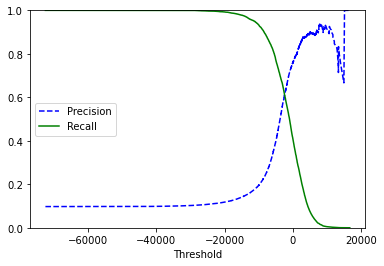

In [45]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_8, y_scores)


def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0, 1])
    
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Từ đồ thị ta có thể thấy mối quan hệ giữa threshold đối với recall và precision

- Khi threshold tăng thì recall luôn luôn giảm
- Khi threshold tăng thì precision có thể tăng hoặc cũng có thể giảm

Bây giờ thì ta có thể chọn được threshold sao cho phù hợp với `precision/recall` tradeoff

Một cách khác nữa để chọn 2 giá trị `precision và recall` theo ý muốn đó là vẽ ra đồ thị phụ thuốc của precision vào recall

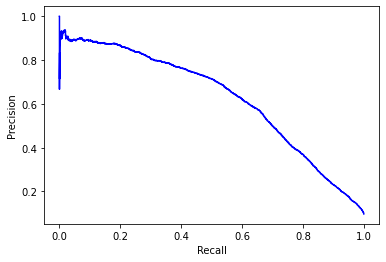

In [46]:
plt.plot(recalls[:-1], precisions[:-1],"b-")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

Bây giờ ví dụ ta muốn đạt được 90% precision, nhìn vào plot thứ nhất mqh giữa precision, recall và threshold. Ta thấy răng ta sẽ cần giá trị threshold là vào khoảng 10,000

In [49]:
y_train_pred_90 = (y_scores > 10000)

print(precision_score(y_train_8, y_train_pred_90))

print(recall_score(y_train_8, y_train_pred_90))

0.9142857142857143
0.005201560468140442


### ROC Curve

Viết tắt của `receiver operating characteristic` (ROC). Đường này giống với đường precision/recall, nhưng thay vì plot ra precision theo recall, ROC curve plots `true positive rate` (tên gọi khác của recall) theo `false positive rate`.

- Thông số FPR là tỉ lệ của negative class bị classified nhầm thành positive. FPR = 1 - `true negative rate` (True negative rate là tỉ số các class negative được classified đúng là negative)
- Thông số TNR còn được gọi là `specifity`.

ROC curve plots `sensivity` (recall) versus `1 - specifity`



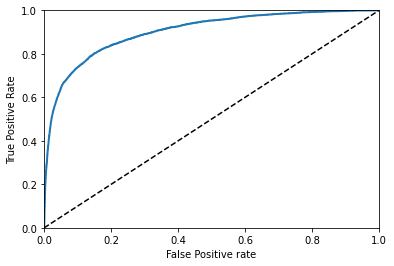

In [51]:
from sklearn.metrics import roc_curve

fpr, tpr, threshold = roc_curve(y_train_8, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

## Multiclass Classification

Thường thì ta có thể sử dụng một số classifier sau đây để phân loại trực tiếp nhiều class:

- Random Forest 
- Naive bayes

Một số loại sau thì strictly dùng cho phân loại 2 class (binary classification):

- Support Vector Machine
- Linear classifier

Tuy nhiên ta có thể kết hợp các bộ binary classifier để có được 1 bộ multinomial classifier bằng cách Như sau. Ví dụ cần phân biệt các số từ 0-9. Ta sẽ sử dụng 10 bộ classifier lần lượt là:

- Bộ classifier digit 0 và không phải digit 0
- Bộ classifier digit 1 và không phải digit 1

...

- Bộ classifier digit 9 và không phải digit 9

Sau đó khi ta muốn classify image, ta sẽ lấy ra decision score từ mỗi classifier và sau đó gán label cho ảnh theo class mà có decision score cao nhất. Đây gọi là `one-versus-all` (OvA) hay còn gọi là `one-versus-rest`.



Một cách khác đó là ta sẽ train binary classifier để phân biệt các cặp digits: phân biệt digit 0 và 1, phân biệt digit 0 và 2, ... Đây gọi là `one-versus-one` (OvO). Nếu như ta có `N` classes, vậy ta sẽ cần `Nx(N-1)/2` classifiers. Ví dụ cho MNIST là có 10 classes => có 10x(10-1)/2 = 45 bộ classifiers. Lợi ích của việc dùng `strategy OvO` này là ta chỉ cần training mỗi classifier trên tập data chỉ gồm 2 digits cần classifier thôi chứ không phải toàn bộ tập train data.

Với hầu hết các classification algorithms thì `OvA` hay được dùng hơn. Tuy có SVM thì hay dùng `OvO`

Sklearn sẽ tự xác định xem khi ta sử dụng `binary classification` cho `multi-class classification` thì nó sẽ chạy `OvA` trừ với SVM thì nó sẽ chạy `OvO`.

## Error Analysis

Nếu như theo các bước ở [Appendix B: exploring data preparation options](../Appendix_ML_project_checklist.md) thì ta sẽ thử nhiều models, tìm ra model tốt nhất với `GridSearchCV`.

Giả sử như ta đã tìm ra được model mong muốn và ta muốn tìm cách để cải thiện nó. Có một cách đó là phân tích loại lỗi mà model gặp phải.

Đầu tiên thì ta có thể nhìn vào `confusion matrix`. Sử dụng hàm `cross_val_predict()` để tính ra prediction cho tập dữ liệu, sau đó gọi hàm `confusion_matrix` để tính toán

In [52]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)

conf_mx

array([[6112,    0,   13,   10,    3,   14,   11,    2,   41,   10],
       [   8, 6699,   42,   35,    8,   38,   13,   12,  184,   26],
       [ 146,   50, 5501,  117,   65,   40,   59,   82,  219,   20],
       [ 120,   34,  179, 5493,    9,  331,    9,   46,  167,   80],
       [  64,   22,   65,   35, 5361,   20,   40,   26,  149,  387],
       [ 227,   30,   39,  353,   81, 4273,   76,   34,  412,  145],
       [ 152,   16,  148,   34,   32,  147, 5466,    4,  174,    6],
       [  58,   22,   72,   44,   66,   20,    4, 5798,   72,  377],
       [ 163,   96,  173,  247,   42,  450,   41,   32, 4742,  166],
       [  78,   24,   35,  104,  246,   57,    1,  166,  255, 5283]],
      dtype=int64)

Ta có thể tận dụng giá trị pixel ảnh càng lớn thì màu sắc càng gần màu trắng để đổi ma trận số trên thành ma trận ảnh để có cái nhìn hay hơn về confusion matrix với hàm `plt.matshow`

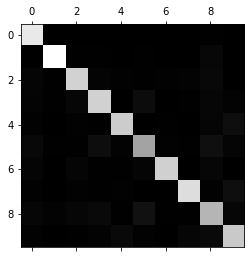

In [53]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

Với màu sắc của ma trận ảnh trên ta có thể thấy răng các class đã được classified khá đúng vì màu sắc tại đường chéo là màu gần trắng. Nhìn vào class 5 thì có vẻ như tối hơn so với các class còn lại thì ta có thể nhận xét rằng classifier đang không thực hiện tốt lắm trên class 5 hoặc cũng có thể class 5 có số lượng ít hơn so với các class còn lại.

Ta có thể kiểm tra cả 2 case trên với class 5.

Đầu tiên, ta sẽ chia các giá trị của ma trận cho số lượng images thuộc về mỗi class ( chính là tổng các dòng).

In [55]:
row_sums = conf_mx.sum(axis=1, keepdims=True)

print(row_sums)

norm_conf_mx = conf_mx / row_sums

[[6216]
 [7065]
 [6299]
 [6468]
 [6169]
 [5670]
 [6179]
 [6533]
 [6152]
 [6249]]


Tiếp theo ta sẽ tô đen đường chéo (tức các class phần loại đúng) và chỉ giữ lại error

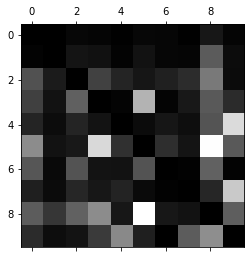

In [56]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Nhìn và ma trận ảnh ta thấy rằng 2 class 8 và 5 có vẻ bị classified nhầm cho nhau => Cần cải thiện tại vị trí này.

## Multilabel Classification

Trong một số trường hợp ta có thể muốn cho đầu ra multiple classes ví dụ như một classifier để nhận diện 3 gương mặt => Một lúc có thể có cả 2 hoặc cả 3 gương mặt xuất hiện trong cùng khung hình => các label ra là [1,0,1] hay là [1,1,1]

## Multiouput Classification

## Exercise

1. Try to build a classifier for the MNIST dataset that achieves over 97% accuracy
on the test set. Hint: the KNeighborsClassifier works quite well for this task;
you just need to find good hyperparameter values (try a grid search on the
weights and n_neighbors hyperparameters).

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt

%matplotlib inline

X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9,random_state=2910,shuffle=True)

print(f"Train_size: {X_train.shape}")
print(f"Test size: {X_test.shape}")

Train_size: (63000, 784)
Test size: (7000, 784)


Các params cần search là:
- Cách tính weights: uniform hoặc distance
- Số K neighbors: 3, 4, 5
- Số fold dùng trong cross_validation: 5


In [28]:
knn_clf = KNeighborsClassifier()

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3, n_jobs = -1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

In [32]:
grid_search.best_estimator_

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [33]:
grid_search.best_score_

0.9731587301587302

In [34]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.976

2. Write a function that can shift an MNIST image in any direction (left, right, up,
or down) by one pixel.5 Then, for each image in the training set, create four shif‐
ted copies (one per direction) and add them to the training set. Finally, train your
best model on this expanded training set and measure its accuracy on the test set.
You should observe that your model performs even better now! This technique of artificially growing the training set is called data augmentation or training set
expansion.


### Data augmentation

In [38]:
from scipy.ndimage.interpolation import shift
import numpy as np

In [39]:
def shift_img(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_img = shift(image, [dy, dx], cval=0, mode='constant')
    return shifted_img.reshape([-1])

In [40]:
X_train_augmented = [img for img in X_train]
y_train_augmented = [label for label in y_train]

# Making data augmentation
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_img(image, dx, dy))
        y_train_augmented.append(label)
        
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)



### Tackle _Titanic_ dataset.

[Kaggle](https://www.kaggle.com/c/titanic)

In [1]:
import pandas as pd

GENDER_SUBMISSION_URL = 'https://drive.google.com/file/d/1e99pRgBdZsTqBT5u1UWN8-mYcB8BhuwM/view?usp=sharing'
TRAIN_URL = 'https://drive.google.com/file/d/1Lu3yPvddx76-gr6OaQpy3Iy2f015Zh31/view?usp=sharing'
TEST_URL = 'https://drive.google.com/file/d/1ti27J8w5W4qRamKzvqes_5udr9TGnDMD/view?usp=sharing'

dwn_url = 'https://drive.google.com/uc?id='

gender_submission = pd.read_csv(f"{dwn_url}{GENDER_SUBMISSION_URL.split('/')[-2]}")
train = pd.read_csv(f"{dwn_url}{TRAIN_URL.split('/')[-2]}")
test = pd.read_csv(f"{dwn_url}{TEST_URL.split('/')[-2]}")

In [49]:
gender_submission.head(5)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [48]:
gender_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int64
 1   Survived     418 non-null    int64
dtypes: int64(2)
memory usage: 6.7 KB


In [45]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Nhận xét: 

Các features Age, Cabin và Embarked có chứa các giá trị null:
- Cabin có 77% là null => ignore feature `Cabin`. 
- Age có 19% là null => replace bằng giá trị tuổi trung bình
- Embarked có 2/891 giá trị là null => bỏ 2 bản ghi có giá trị là null này

In [8]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Các điểm chú ý ở đây là :

- 38% Survived
- Giá vé (Fare) trung bình là 32.2
- Độ tuổi trung bình (Age) là 30

Show some data

In [47]:
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Xem thống kê các features mang giá trị categorical

In [7]:
# watching cabin enum value
print(train['Cabin'].value_counts())

print(f"\n {train['Cabin'].unique()}")

# 


B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

 [nan 'C85' 'C123' 'E46' 'G6' 'C103' 'D56' 'A6' 'C23 C25 C27' 'B78' 'D33'
 'B30' 'C52' 'B28' 'C83' 'F33' 'F G73' 'E31' 'A5' 'D10 D12' 'D26' 'C110'
 'B58 B60' 'E101' 'F E69' 'D47' 'B86' 'F2' 'C2' 'E33' 'B19' 'A7' 'C49'
 'F4' 'A32' 'B4' 'B80' 'A31' 'D36' 'D15' 'C93' 'C78' 'D35' 'C87' 'B77'
 'E67' 'B94' 'C125' 'C99' 'C118' 'D7' 'A19' 'B49' 'D' 'C22 C26' 'C106'
 'C65' 'E36' 'C54' 'B57 B59 B63 B66' 'C7' 'E34' 'C32' 'B18' 'C124' 'C91'
 'E40' 'T' 'C128' 'D37' 'B35' 'E50' 'C82' 'B96 B98' 'E10' 'E44' 'A34'
 'C104' 'C111' 'C92' 'E38' 'D21' 'E12' 'E63' 'A14' 'B37' 'C30' 'D20' 'B79'
 'E25' 'D46' 'B73' 'C95' 'B38' 'B39' 'B22' 'C86' 'C70' 'A16' 'C101' 'C68'
 'A10' 'E68' 'B41' 'A20' 'D19' 'D50' 'D9' 'A23' 'B50' 'A26' 'D48' 'E58'
 'C126' 'B71' 'B51 B53 B55' 'D49' 'B5' 'B20' 'F G

In [6]:
print(f"Embarked: \n{train['Embarked'].value_counts()}")

Embarked: 
S    644
C    168
Q     77
Name: Embarked, dtype: int64


In [9]:
train.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [10]:
train.Pclass.value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [11]:
train.Sex.value_counts()

male      577
female    314
Name: Sex, dtype: int64

Xem tỉ lệ phụ nữ sống sót trong tập train

In [50]:
women = train.loc[train.Sex == 'female']['Survived']
rate_women = sum(women)/len(women)

print(f"% of women who survived: ", rate_women)

% of women who survived:  0.7420382165605095


In [51]:
men = train.loc[train.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)

print("% of men who survived:", rate_men)

% of men who survived: 0.18890814558058924


File `gender_submission.csv` cho là 100% phụ nữ sống sót và không có đàn ông sống sót, ta thấy răng nó cũng khá sát với kết quả thống kế ở phía trên.

Dựng `DataframeSelector`

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

Tạo pipline để tính toán và gán giá trị trung bình cho các features

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_pipline = Pipeline([
    ("select_numeric", DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
    ("imputer", SimpleImputer(strategy="median"))
])

In [14]:
num_pipline.fit_transform(train)

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

In [15]:
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # Lấy index 0 vì .value_counts sẽ trả về series với các giá trị được sắp xếp theo tần suất giảm dần
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [16]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

In [17]:
cat_pipline = Pipeline([
    ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
    ("imputer", MostFrequentImputer()),
    ("cat_encoder", OneHotEncoder(sparse=False))
])

In [19]:
cat_pipline.fit_transform(train)

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

Join numerical and categorical pipelines:

In [21]:
from sklearn.pipeline import FeatureUnion

preprocess_pipeline = FeatureUnion(transformer_list = [
    ("num_pipline", num_pipline),
    ("cat_pipline", cat_pipline)
])

In [22]:
X_train = preprocess_pipeline.fit_transform(train)

X_train

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  1.,  0.]])

In [23]:
y_train = train["Survived"]

Training model RandomForest

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

forest_clf = RandomForestClassifier(n_estimators=100, random_state=2910)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8103745318352059

Accuracy on test set

In [26]:
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=2910)

In [29]:
from sklearn.metrics import accuracy_score

y_test = gender_submission['Survived']
X_test = preprocess_pipeline.fit_transform(test)
y_pred = forest_clf.predict(X_test)

print(f"Accurcy score: {accuracy_score(y_test, y_pred)}")

Accurcy score: 0.8205741626794258


## Build spam classifier

Download dataset

In [1]:
import pandas as pd
import tarfile
import urllib.request
from tqdm import tqdm
import os


DOWNLOAD_ROOT = 'https://spamassassin.apache.org/old/publiccorpus/'
HAM_URL = DOWNLOAD_ROOT + "20030228_easy_ham.tar.bz2"
SPAM_URL = DOWNLOAD_ROOT + "20030228_spam.tar.bz2"
SPAM_PATH = os.path.join("datasets", "spam")

def fetch_spam_data(spam_url=SPAM_URL, spam_path = SPAM_PATH):
    if not os.path.isdir(spam_path):
        os.makedirs(spam_path)
    for filename, url in tqdm((("ham.tar.bz2", HAM_URL), ("spam.tar.bz2", SPAM_URL))):
        path = os.path.join(spam_path, filename)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
        tar_bz2_file = tarfile.open(path)
        tar_bz2_file.extractall(path=SPAM_PATH)
        tar_bz2_file.close()

In [2]:
fetch_spam_data()

100%|██████████| 2/2 [00:09<00:00,  4.98s/it]


Load data from downloaded file

In [3]:
HAM_DIR = os.path.join(SPAM_PATH, "easy_ham")
SPAM_DIR = os.path.join(SPAM_PATH, "spam")

ham_filenames = [filename for filename in sorted(os.listdir(HAM_DIR)) if len(filename) > 20 ]
spam_filenames = [filename for filename in sorted(os.listdir(SPAM_DIR)) if len(filename) > 20 ]

In [4]:
len(ham_filenames)

2500

In [5]:
len(spam_filenames)

500

parse email using `email` module 

In [6]:
import email
import email.policy

def load_email(is_spam, filename, spam_path=SPAM_PATH):
    directory = "spam" if is_spam else "easy_ham"
    with open(os.path.join(SPAM_PATH, directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [7]:
ham_emails = [load_email(is_spam=False,filename=filename) for filename in ham_filenames]
spam_emails = [load_email(is_spam=True,filename=filename) for filename in spam_filenames]

In [8]:
print(ham_emails[1].get_content().strip())

Martin A posted:
Tassos Papadopoulos, the Greek sculptor behind the plan, judged that the
 limestone of Mount Kerdylio, 70 miles east of Salonika and not far from the
 Mount Athos monastic community, was ideal for the patriotic sculpture. 
 
 As well as Alexander's granite features, 240 ft high and 170 ft wide, a
 museum, a restored amphitheatre and car park for admiring crowds are
planned
---------------------
So is this mountain limestone or granite?
If it's limestone, it'll weather pretty fast.

------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/


In [9]:
print(spam_emails[6].get_content().strip())

Help wanted.  We are a 14 year old fortune 500 company, that is
growing at a tremendous rate.  We are looking for individuals who
want to work from home.

This is an opportunity to make an excellent income.  No experience
is required.  We will train you.

So if you are looking to be employed from home with a career that has
vast opportunities, then go:

http://www.basetel.com/wealthnow

We are looking for energetic and self motivated people.  If that is you
than click on the link and fill out the form, and one of our
employement specialist will contact you.

To be removed from our link simple go to:

http://www.basetel.com/remove.html


4139vOLW7-758DoDY1425FRhM1-764SMFc8513fCsLl40


Có một số email thuộc loại multipart, tức là nó sẽ có cả ảnh, attachments, ... Ta sẽ show xem data của ta có những kiểu dữ liệu như thế nào

In [10]:
def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(", ".join([
            get_email_structure(sub_email)
            for sub_email in payload
        ]))
    else:
        return email.get_content_type()

In [11]:
from collections import Counter

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] +=1
    return structures

In [12]:
structures_counter(ham_emails).most_common()

[('text/plain', 2408),
 ('multipart(text/plain, application/pgp-signature)', 66),
 ('multipart(text/plain, text/html)', 8),
 ('multipart(text/plain, text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, text/enriched)', 1),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 1),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  1),
 ('multipart(text/plain, video/mng)', 1),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(text/plain, application/x-pkcs7-signature)', 1),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  1),
 ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))',
  1),
 ('multipart(text/plain, application/x-java-applet)', 1)]

In [13]:
structures_counter(spam_emails).most_common()

[('text/plain', 218),
 ('text/html', 183),
 ('multipart(text/plain, text/html)', 45),
 ('multipart(text/html)', 20),
 ('multipart(text/plain)', 19),
 ('multipart(multipart(text/html))', 5),
 ('multipart(text/plain, image/jpeg)', 3),
 ('multipart(text/html, application/octet-stream)', 2),
 ('multipart(text/plain, application/octet-stream)', 1),
 ('multipart(text/html, text/plain)', 1),
 ('multipart(multipart(text/html), application/octet-stream, image/jpeg)', 1),
 ('multipart(multipart(text/plain, text/html), image/gif)', 1),
 ('multipart/alternative', 1)]

Xem header của các email

In [14]:
for header, value in spam_emails[0].items():
    print(header, ":", value)

Return-Path : <12a1mailbot1@web.de>
Delivered-To : zzzz@localhost.spamassassin.taint.org
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 136B943C32	for <zzzz@localhost>; Thu, 22 Aug 2002 08:17:21 -0400 (EDT)
Received : from mail.webnote.net [193.120.211.219]	by localhost with POP3 (fetchmail-5.9.0)	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 13:17:21 +0100 (IST)
Received : from dd_it7 ([210.97.77.167])	by webnote.net (8.9.3/8.9.3) with ESMTP id NAA04623	for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 13:09:41 +0100
From : 12a1mailbot1@web.de
Received : from r-smtp.korea.com - 203.122.2.197 by dd_it7  with Microsoft SMTPSVC(5.5.1775.675.6);	 Sat, 24 Aug 2002 09:42:10 +0900
To : dcek1a1@netsgo.com
Subject : Life Insurance - Why Pay More?
Date : Wed, 21 Aug 2002 20:31:57 -1600
MIME-Version : 1.0
Message-ID : <0103c1042001882DD_IT7@dd_it7>
Content-Type : text/html; charset="iso-8859-1"
Content-Transfer-Encoding : qu

Phần header chứa khá nhiều thông tin như người nhận, người gửi, etc... tuy nhiên thứ ta quan tâm duy nhất trong header là `Subject` header

In [15]:
spam_emails[0]['Subject']

'Life Insurance - Why Pay More?'

Split data into test set and training set

In [40]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd


X = np.array(ham_emails + spam_emails, dtype=object)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train size: {X_train.shape}\nTest size: {X_test.shape}")

Train size: (2400,)
Test size: (600,)


Function to convert HTML to text

In [41]:
import re
from html import unescape

def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

In [44]:
html_spam_emails = [email for email in X_train[y_train == 1]
                    if get_email_structure(email) == 'text/html']
sample_html_spam = html_spam_emails[7]
print(sample_html_spam.get_content().strip()[:1000], "...")


<HTML><HEAD><TITLE></TITLE><META http-equiv="Content-Type" content="text/html; charset=windows-1252"><STYLE>A:link {TEX-DECORATION: none}A:active {TEXT-DECORATION: none}A:visited {TEXT-DECORATION: none}A:hover {COLOR: #0033ff; TEXT-DECORATION: underline}</STYLE><META content="MSHTML 6.00.2713.1100" name="GENERATOR"></HEAD>
<BODY text="#000000" vLink="#0033ff" link="#0033ff" bgColor="#CCCC99"><TABLE borderColor="#660000" cellSpacing="0" cellPadding="0" border="0" width="100%"><TR><TD bgColor="#CCCC99" valign="top" colspan="2" height="27">
<font size="6" face="Arial, Helvetica, sans-serif" color="#660000">
<b>OTC</b></font></TD></TR><TR><TD height="2" bgcolor="#6a694f">
<font size="5" face="Times New Roman, Times, serif" color="#FFFFFF">
<b>&nbsp;Newsletter</b></font></TD><TD height="2" bgcolor="#6a694f"><div align="right"><font color="#FFFFFF">
<b>Discover Tomorrow's Winners&nbsp;</b></font></div></TD></TR><TR><TD height="25" colspan="2" bgcolor="#CCCC99"><table width="100%" border="0" 

In [45]:
print(html_to_plain_text(sample_html_spam.get_content())[:1000], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Watch for analyst "Strong Buy Recommendations" and several advisory newsletters picking CBYI.  CBYI has filed to be traded on the OTCBB, share prices historically INCREASE when companies get listed on this larger trading exchange. CBYI is trading around 25 cents and should skyrocket to $2.66 - $3.25 a share in the near future.
Put CBYI on your watch list, acquire a position TODAY.
REASONS TO INVEST IN CBYI
A profitable company and is on track to beat ALL earnings estimates!
One of the FASTEST growing distributors in environmental & safety equipment instruments.
Excellent management team, several EXCLUSIVE contracts.  IMPRESSIVE client list including the U.S. Air Force, Anheuser-Busch, Chevron Refining and Mitsubishi Heavy Industries, GE-Energy & Environmental Research.
RAPIDLY GROWING INDUSTRY
Industry revenues exceed $900 million, estimates indicate that there could be as much as $25 billi

In [46]:
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except:
            content = str(part.get_payload())
        if ctype == 'text/plain':
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)
        

In [47]:
print(email_to_text(sample_html_spam)[:100], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Wat ...


STEM word với NLTK lib

In [49]:
try:
    import nltk

    stemmer = nltk.PorterStemmer()
    for word in ("Computations", "Computation", "Computing", "Computed", "Compute", "Compulsive"):
        print(word, "=>", stemmer.stem(word))
except ImportError:
    print("Error: stemming requires the NLTK module.")
    stemmer = None

Computations => comput
Computation => comput
Computing => comput
Computed => comput
Compute => comput
Compulsive => compuls


In [51]:
%pip install urlextract

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Extract url ra vowis lib `urlextract`

In [53]:
try:
    import urlextract # may require an Internet connection to download root domain names
    
    url_extractor = urlextract.URLExtract()
    print(url_extractor.find_urls("Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s"))
except ImportError:
    print("Error: replacing URLs requires the urlextract module.")
    url_extractor = None

['github.com', 'https://youtu.be/7Pq-S557XQU?t=3m32s']


Như vậy ta sẽ tạo một transform có các options thực hiện như sau:

- CHuyển đổi email sang text
- Đối hết chữ thành lower case
- replace hết tất cả các url thành từ `" URL "`
- replace hết tất cả các số thành từ `NUMBER`
- replace hết tất cả các dấu cấu như `?:\/...` thành dấu cách
- split ra các word và dùng Counter để đếm số lượng các unique word
- Sử dụng stemming để stem các word và áp dụng lại Counter để được bag of words cuối cùng

In [54]:
from sklearn.base import BaseEstimator, TransformerMixin

class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case = True, remove_punctuation=True,
                 replace_urls=True, replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ""
            if self.lower_case:
                text = text.lower()
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*(?:[eE]\d+))?', 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)

In [55]:
X_few = X_train[:3]
X_few_wordcounts = EmailToWordCounterTransformer().fit_transform(X_few)
X_few_wordcounts

array([Counter({'chuck': 1, 'murcko': 1, 'wrote': 1, 'stuff': 1, 'yawn': 1, 'r': 1}),
       Counter({'the': 11, 'of': 9, 'and': 8, 'all': 3, 'christian': 3, 'to': 3, 'by': 3, 'jefferson': 2, 'i': 2, 'have': 2, 'superstit': 2, 'one': 2, 'on': 2, 'been': 2, 'ha': 2, 'half': 2, 'rogueri': 2, 'teach': 2, 'jesu': 2, 'some': 1, 'interest': 1, 'quot': 1, 'url': 1, 'thoma': 1, 'examin': 1, 'known': 1, 'word': 1, 'do': 1, 'not': 1, 'find': 1, 'in': 1, 'our': 1, 'particular': 1, 'redeem': 1, 'featur': 1, 'they': 1, 'are': 1, 'alik': 1, 'found': 1, 'fabl': 1, 'mytholog': 1, 'million': 1, 'innoc': 1, 'men': 1, 'women': 1, 'children': 1, 'sinc': 1, 'introduct': 1, 'burnt': 1, 'tortur': 1, 'fine': 1, 'imprison': 1, 'what': 1, 'effect': 1, 'thi': 1, 'coercion': 1, 'make': 1, 'world': 1, 'fool': 1, 'other': 1, 'hypocrit': 1, 'support': 1, 'error': 1, 'over': 1, 'earth': 1, 'six': 1, 'histor': 1, 'american': 1, 'john': 1, 'e': 1, 'remsburg': 1, 'letter': 1, 'william': 1, 'short': 1, 'again': 1, 'becom

Convert các word thành vector

- `fit` method sẽ tính toán ra vocabulary hay từ điển cho các từ và gán các từ với index lần lượt từ 0 -> ...
- `transform` method sẽ tính toán ra vector của từng email, trong đó:
    * `row` là đại diện cho index của từng email
    * `col` là đại diện cho index của từ trong từ điển
    * `data` là giá trị đếm số từ xuất hiện, giá trị này là giá trị của phần tử tại hàng `row` cột `col` trong ma trận các vector email

In [72]:
from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size] 
        self.most_common_ = most_common
        self.vocabulary_ = {word: index + 1 for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)), shape=(len(X), self.vocabulary_size + 1))
        

In [73]:
vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=10)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors

<3x11 sparse matrix of type '<class 'numpy.intc'>'
	with 20 stored elements in Compressed Sparse Row format>

In [74]:
X_few_vectors.toarray()

array([[ 6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [99, 11,  9,  8,  3,  1,  3,  1,  3,  2,  3],
       [67,  0,  1,  2,  3,  4,  1,  2,  0,  1,  0]], dtype=int32)

In [75]:
vocab_transformer.vocabulary_

{'the': 1,
 'of': 2,
 'and': 3,
 'to': 4,
 'url': 5,
 'all': 6,
 'in': 7,
 'christian': 8,
 'on': 9,
 'by': 10}

In [79]:
from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ("email_to_wordcount", EmailToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer())
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

Training model với Logistic Regression

In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(solver='liblinear', random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_train, cv=3, verbose=3)

score.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] END ................................ score: (test=0.981) total time=   0.0s
[CV] END ................................ score: (test=0.985) total time=   0.1s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV] END ................................ score: (test=0.990) total time=   0.1s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s finished


0.9854166666666666

In [80]:
from sklearn.metrics import precision_score, recall_score

X_test_transformed = preprocess_pipeline.transform(X_test)

log_clf = LogisticRegression(solver="liblinear", random_state=42)
log_clf.fit(X_train_transformed, y_train)

y_pred = log_clf.predict(X_test_transformed)

print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_pred)))

Precision: 96.88%
Recall: 97.89%
